In [1]:
import scanpy as sc
data_dir = '../../dataset/merfish_human_neocortex_SSL.h5ad'
adata = sc.read_h5ad(data_dir)
adata.X = adata.raw.X.copy()
print(adata.X)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12532157 stored elements and shape (234125, 300)>
  Coords	Values
  (0, 9)	5
  (0, 16)	2
  (0, 18)	3
  (0, 23)	1
  (0, 24)	1
  (0, 25)	5
  (0, 27)	1
  (0, 28)	1
  (0, 29)	6
  (0, 30)	1
  (0, 31)	1
  (0, 34)	6
  (0, 37)	1
  (0, 45)	21
  (0, 46)	1
  (0, 53)	1
  (0, 58)	1
  (0, 60)	1
  (0, 61)	1
  (0, 67)	2
  (0, 68)	1
  (0, 74)	1
  (0, 81)	1
  (0, 86)	1
  (0, 87)	2
  :	:
  (234123, 261)	1
  (234124, 14)	2
  (234124, 18)	1
  (234124, 25)	3
  (234124, 55)	1
  (234124, 58)	1
  (234124, 62)	1
  (234124, 66)	1
  (234124, 75)	1
  (234124, 89)	1
  (234124, 104)	1
  (234124, 106)	1
  (234124, 107)	1
  (234124, 117)	2
  (234124, 126)	1
  (234124, 146)	3
  (234124, 171)	1
  (234124, 184)	1
  (234124, 200)	1
  (234124, 215)	3
  (234124, 221)	1
  (234124, 237)	1
  (234124, 251)	1
  (234124, 261)	1
  (234124, 297)	1


In [2]:
import scanpy as sc
import torch
from torch import nn
import lightning.pytorch as pl
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder

# 设置你的 .ckpt 文件路径
ckpt_path = "../../sc_pretrained/Pretrained Models/GPMask.ckpt"

# 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 如果没有实际数据路径，可以设置为None

# 加载预训练模型
estim.model = MLPAutoEncoder.load_from_checkpoint(
    ckpt_path,
    gene_dim=19331,  # 根据你的数据调整
    batch_size=128,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
estim.model

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [3]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

29

In [4]:
import pandas as pd
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
var_df

,feature_id,feature_name
0,ENSG00000186092,OR4F5
1,ENSG00000284733,OR4F29
2,ENSG00000284662,OR4F16
3,ENSG00000187634,SAMD11
4,ENSG00000188976,NOC2L
...,...,...
19326,ENSG00000288702,UGT1A3
19327,ENSG00000288705,UGT1A5
19328,ENSG00000182484,WASH6P
19329,ENSG00000288622,PDCD6-AHRR


In [5]:
all_genes = var_df['feature_name'].tolist()
all_genes

['OR4F5',
 'OR4F29',
 'OR4F16',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15',
 'AGRN',
 'RNF223',
 'C1orf159',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'UBE2J2',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20',
 'ANKRD65',
 'TMEM88B',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'FNDC10',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'SLC35E2B',
 'CDK11A',
 'NADK',
 'GNB1',
 'CALML6',
 'TMEM52',
 'CFAP74',
 'GABRD',
 'PRKCZ',
 'FAAP20',
 'SKI',
 'MORN1',
 'RER1',
 'PEX10',
 'PLCH2',
 'PANK4',
 'HES5',
 'TNFRSF14',
 'PRXL2B',
 'MMEL1',
 'TTC34',
 'ACTRT2',
 'PRDM16',
 'ARHGEF16',
 'MEGF6',
 'TPRG1L',
 'WRAP73',
 'TP73',
 'CCDC27',
 'SMIM1',
 'LRRC47',
 'CEP104',
 'DFFB',
 'C1orf174',
 'AJAP1',
 'NPHP4',
 'KCNAB2',
 'CHD5',
 'RPL22',
 'RNF207',
 'ICMT',
 'HES3',
 'GPR153',
 'ACOT7',
 'HES2',
 'ESPN',
 'TNFRSF25',
 'PLEKHG5',
 'NOL9',
 'TAS1R1',
 'ZBTB48',
 'KLH

In [6]:
adata.var['gene_name']=adata.var.index
adata.var['gene_name']

features
TFAP2C          TFAP2C
HGF                HGF
NAMPT            NAMPT
VIM                VIM
CD38              CD38
               ...    
LINC01170    LINC01170
SATB1-AS1    SATB1-AS1
CFAP54          CFAP54
RMST              RMST
NOTCH1          NOTCH1
Name: gene_name, Length: 300, dtype: object

In [7]:
import numpy as np
# 初始化一个新的数据矩阵，形状为 (adata.X.shape[0], len(all_genes))，填充为零
new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

In [8]:
existing_genes = adata.var['gene_name']
existing_genes

features
TFAP2C          TFAP2C
HGF                HGF
NAMPT            NAMPT
VIM                VIM
CD38              CD38
               ...    
LINC01170    LINC01170
SATB1-AS1    SATB1-AS1
CFAP54          CFAP54
RMST              RMST
NOTCH1          NOTCH1
Name: gene_name, Length: 300, dtype: object

In [9]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes


匹配的基因数量: 281
匹配的基因列表: {'spp1', 'col4a1', 'ccn1', 'igfbp7', 'bmper', 'klhl14', 'hmga2', 'hopx', 'cdh12', 'isg15', 'cntnap2', 'eomes', 'cfap299', 'vim', 'kirrel3', 'angpt1', 'ppp1r16b', 'ablim1', 'rbfox3', 'gpx3', 'lama2', 'gpr17', 'rit2', 'flt1', 'znf536', 'olig1', 'runx1t1', 'il1rapl2', 'nxph1', 'zfp36', 'nhlh2', 'glul', 'c21orf58', 'nkain2', 'pou6f2', 'ugt8', 'myt1l', 'dpf3', 'dach1', 'nampt', 'plp1', 'enpp6', 'kcns3', 'pcsk6', 'ascl1', 'rorb', 'cd99', 'pdgfra', 'gpc5', 'fam160a1', 'rgs6', 'lhfpl3', 'enpp2', 'mx1', 'cpne4', 'arx', 'sema5a', 'cux2', 'gad1', 'cpne8', 'slc35f3', 'igfbp5', 'fos', 'hmgb2', 'agbl1', 'disc1', 'inpp4b', 'camk2a', 'znf804b', 'dock10', 'abcb1', 'neurod1', 'grik1', 'slc1a2', 'fn1', 'lrig1', 'prex2', 'rnf220', 'kcnh5', 'slc6a1', 'pdzrn4', 'col24a1', 'chrdl1', 'klhl4', 'cebpd', 'abca8', 'cxcl14', 'st8sia5', 'ebf3', 'satb2', 'tns3', 'id3', 'cd38', 'gad2', 'prox1', 'gja1', 'olfm3', 'tshz2', 'ifi6', 'runx1', 'sst', 'apbb1ip', 'lhfpl6', 'itga2', 'cfap54', 'mdga1', 'cl

{'dlx6-as1',
 'fam106a',
 'kcnq1ot1',
 'lhx1-dt',
 'linc00609',
 'linc01170',
 'linc01619',
 'linc01965',
 'linc02147',
 'linc02487',
 'lncarod',
 'neat1',
 'nfia-as2',
 'nr2f2-as1',
 'obi1-as1',
 'rmst',
 'satb1-as1',
 'sgo1-as1',
 'tctex1d1'}

In [10]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
gene_to_index

{'or4f5': 0,
 'or4f29': 1,
 'or4f16': 2,
 'samd11': 3,
 'noc2l': 4,
 'klhl17': 5,
 'plekhn1': 6,
 'perm1': 7,
 'hes4': 8,
 'isg15': 9,
 'agrn': 10,
 'rnf223': 11,
 'c1orf159': 12,
 'ttll10': 13,
 'tnfrsf18': 14,
 'tnfrsf4': 15,
 'sdf4': 16,
 'b3galt6': 17,
 'c1qtnf12': 18,
 'ube2j2': 19,
 'scnn1d': 20,
 'acap3': 21,
 'pusl1': 22,
 'ints11': 23,
 'cptp': 24,
 'tas1r3': 25,
 'dvl1': 26,
 'mxra8': 27,
 'aurkaip1': 28,
 'ccnl2': 29,
 'mrpl20': 30,
 'ankrd65': 31,
 'tmem88b': 32,
 'vwa1': 33,
 'atad3c': 34,
 'atad3b': 35,
 'atad3a': 36,
 'tmem240': 37,
 'ssu72': 38,
 'fndc10': 39,
 'mib2': 40,
 'mmp23b': 41,
 'cdk11b': 42,
 'slc35e2b': 43,
 'cdk11a': 44,
 'nadk': 45,
 'gnb1': 46,
 'calml6': 47,
 'tmem52': 48,
 'cfap74': 49,
 'gabrd': 50,
 'prkcz': 51,
 'faap20': 52,
 'ski': 53,
 'morn1': 54,
 'rer1': 55,
 'pex10': 56,
 'plch2': 57,
 'pank4': 58,
 'hes5': 59,
 'tnfrsf14': 60,
 'prxl2b': 61,
 'mmel1': 62,
 'ttc34': 63,
 'actrt2': 64,
 'prdm16': 65,
 'arhgef16': 66,
 'megf6': 67,
 'tprg1l': 68

In [11]:
only_in_all_genes = all_genes_set - adata_genes_set

only_in_adata_genes = adata_genes_set - all_genes_set

# 输出结果
print(f"仅在 all_genes 中存在的基因数量: {len(only_in_all_genes)}")
print(f"仅在 all_genes 中存在的基因: {only_in_all_genes}")

print(f"仅在 adata_genes 中存在的基因数量: {len(only_in_adata_genes)}")
print(f"仅在 adata_genes 中存在的基因: {only_in_adata_genes}")


仅在 all_genes 中存在的基因数量: 19050
仅在 all_genes 中存在的基因: {'mthfr', 'fbxo33', 'reep5', 'mylk', 'spic', 'gpbp1l1', 'prom1', 'fshb', 'adgrf5', 'clp1', 'fam209b', 'retsat', 'kcnip3', 'nadsyn1', 'heatr5b', 'tlcd3a', 'pygm', 'pip5kl1', 'nsmce2', 'fcmr', 'iqank1', 'spout1', 'tcp11l2', 'gemin7', 'armcx3', 'ftcd', 'plxnb2', 'arl2bp', 'mettl7a', 'sec61a2', 'spata5', 'myoz3', 'usp17l28', 'dynlt2', 'cmip', 'tm4sf18', 'dynlt1', 'tuba1a', 'adamts8', 'sirt5', 'dse', 'trim33', 'rpl22', 'cetn3', 'txnip', 'gfra2', 'il2rb', 'zswim4', 'fam83h', 'gstz1', 'pip4k2c', 'mertk', 'bex2', 'il2ra', 'il7', 'efemp1', 'apoc1', 'pclaf', 'kxd1', 'tp53tg3c', 'p2rx5', 'nsmce3', 'ddx55', 'cap2', 'cygb', 'mbd3l4', 'fam43a', 'sox2', 'dpys', 'mrps36', 'ttc39a', 'lta', 'inava', 'slc26a5', 'hsp90ab1', 'or8j1', 'art5', 'skiv2l', 'gls2', 'cgb8', 'prss57', 'tcfl5', 'fga', 'tsga10', 'slc31a2', 'cacfd1', 'xrcc6', 'cmtm6', 'chrm4', 'snx19', 'rab40c', 'abhd14a', 'znf706', 'slc35g2', 'gata3', 'pla2g10', 's100z', 'mapkap1', 'rnpepl1', 'irak3'

In [12]:
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

Gene tctex1d1 not found in all_genes list


Gene linc02487 not found in all_genes list
Gene nfia-as2 not found in all_genes list
Gene lncarod not found in all_genes list
Gene dlx6-as1 not found in all_genes list
Gene sgo1-as1 not found in all_genes list


Gene linc02147 not found in all_genes list
Gene linc01965 not found in all_genes list
Gene linc00609 not found in all_genes list
Gene linc01619 not found in all_genes list
Gene kcnq1ot1 not found in all_genes list
Gene obi1-as1 not found in all_genes list
Gene fam106a not found in all_genes list
Gene neat1 not found in all_genes list
Gene nr2f2-as1 not found in all_genes list
Gene lhx1-dt not found in all_genes list
Gene linc01170 not found in all_genes list
Gene satb1-as1 not found in all_genes list
Gene rmst not found in all_genes list


In [13]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

cuda


MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [14]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.encoder.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻最后两层
for param in list(estim.model.encoder.parameters())[-5:]:
    param.requires_grad = True

In [15]:
from torch.optim import AdamW
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [16]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [17]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 1.4545520783680477, Validation Loss: 0.9529107132824984
Validation loss improved to 0.9529107132824984, resetting patience.


Epoch 2, Train Loss: 1.111773490859232, Validation Loss: 0.8853807544708252
Validation loss improved to 0.8853807544708252, resetting patience.


Epoch 3, Train Loss: 1.077023272492009, Validation Loss: 0.8720082972266457
Validation loss improved to 0.8720082972266457, resetting patience.


Epoch 4, Train Loss: 1.058809718380302, Validation Loss: 0.8816387763890353
No improvement in validation loss. Patience counter: 1/20


Epoch 5, Train Loss: 1.0434466914494087, Validation Loss: 0.8526416338573802
Validation loss improved to 0.8526416338573802, resetting patience.


Epoch 6, Train Loss: 1.0392228563626607, Validation Loss: 0.8518395072763616
Validation loss improved to 0.8518395072763616, resetting patience.


Epoch 7, Train Loss: 1.028002467032618, Validation Loss: 0.850006328496066
Validation loss improved to 0.850006328496066, resetting patience.


Epoch 8, Train Loss: 1.0236073102362913, Validation Loss: 0.8446676323630593
Validation loss improved to 0.8446676323630593, resetting patience.


Epoch 9, Train Loss: 1.0175223965648559, Validation Loss: 0.8582462254437533
No improvement in validation loss. Patience counter: 1/20


Epoch 10, Train Loss: 1.0133527250237804, Validation Loss: 0.8300430477749218
Validation loss improved to 0.8300430477749218, resetting patience.


Epoch 11, Train Loss: 1.0063722467720275, Validation Loss: 0.8189290935342962
Validation loss improved to 0.8189290935342962, resetting patience.


Epoch 12, Train Loss: 1.0049173408053427, Validation Loss: 0.8332285508242521
No improvement in validation loss. Patience counter: 1/20


Epoch 13, Train Loss: 1.0020878612762498, Validation Loss: 0.8331867096640847
No improvement in validation loss. Patience counter: 2/20


Epoch 14, Train Loss: 0.9982907826969346, Validation Loss: 0.8397776157205755
No improvement in validation loss. Patience counter: 3/20


Epoch 15, Train Loss: 0.9989737308555799, Validation Loss: 0.8191464133696122
No improvement in validation loss. Patience counter: 4/20


Epoch 16, Train Loss: 0.9939391833092439, Validation Loss: 0.8088114216110923
Validation loss improved to 0.8088114216110923, resetting patience.


Epoch 17, Train Loss: 0.9883576138795679, Validation Loss: 0.829517325704748
No improvement in validation loss. Patience counter: 1/20


Epoch 18, Train Loss: 0.989117896389347, Validation Loss: 0.8090709458697926
No improvement in validation loss. Patience counter: 2/20


Epoch 19, Train Loss: 0.9840169771865975, Validation Loss: 0.81305072480982
No improvement in validation loss. Patience counter: 3/20


Epoch 20, Train Loss: 0.9848548521947154, Validation Loss: 0.8186069651083513
No improvement in validation loss. Patience counter: 4/20


Epoch 21, Train Loss: 0.9805472000886648, Validation Loss: 0.8013191303339872
Validation loss improved to 0.8013191303339872, resetting patience.


Epoch 22, Train Loss: 0.9805177954097543, Validation Loss: 0.8166214812885632
No improvement in validation loss. Patience counter: 1/20


Epoch 23, Train Loss: 0.9791180293695895, Validation Loss: 0.8024281473593279
No improvement in validation loss. Patience counter: 2/20


Epoch 24, Train Loss: 0.9803390438253297, Validation Loss: 0.8356458965214816
No improvement in validation loss. Patience counter: 3/20


Epoch 25, Train Loss: 0.9743623789821538, Validation Loss: 0.7999408637393605
Validation loss improved to 0.7999408637393605, resetting patience.


Epoch 26, Train Loss: 0.9756410596521453, Validation Loss: 0.8116472348299894
No improvement in validation loss. Patience counter: 1/20


Epoch 27, Train Loss: 0.973745559641014, Validation Loss: 0.7989648697592996
Validation loss improved to 0.7989648697592996, resetting patience.


Epoch 28, Train Loss: 0.9749896649175283, Validation Loss: 0.7992861754244024
No improvement in validation loss. Patience counter: 1/20


Epoch 29, Train Loss: 0.9735891231329157, Validation Loss: 0.7958744905211709
Validation loss improved to 0.7958744905211709, resetting patience.


Epoch 30, Train Loss: 0.9725954956044265, Validation Loss: 0.8077131754701787
No improvement in validation loss. Patience counter: 1/20


Epoch 31, Train Loss: 0.9749793260010028, Validation Loss: 0.7995305421135642
No improvement in validation loss. Patience counter: 2/20


Epoch 32, Train Loss: 0.9729344033804096, Validation Loss: 0.8027078812772578
No improvement in validation loss. Patience counter: 3/20


Epoch 33, Train Loss: 0.9729040497266902, Validation Loss: 0.789040396863764
Validation loss improved to 0.789040396863764, resetting patience.


Epoch 34, Train Loss: 0.9693143385913947, Validation Loss: 0.7958666374466636
No improvement in validation loss. Patience counter: 1/20


Epoch 35, Train Loss: 0.9724091697632569, Validation Loss: 0.8097654037042098
No improvement in validation loss. Patience counter: 2/20


Epoch 36, Train Loss: 0.9681345819496345, Validation Loss: 0.7975698141618208
No improvement in validation loss. Patience counter: 3/20


Epoch 37, Train Loss: 0.9647514690280798, Validation Loss: 0.7835650513388894
Validation loss improved to 0.7835650513388894, resetting patience.


Epoch 38, Train Loss: 0.9669853683377876, Validation Loss: 0.7933775136687539
No improvement in validation loss. Patience counter: 1/20


Epoch 39, Train Loss: 0.9668058131375785, Validation Loss: 0.7969451938975941
No improvement in validation loss. Patience counter: 2/20


Epoch 40, Train Loss: 0.9715835412064164, Validation Loss: 0.7997565859014337
No improvement in validation loss. Patience counter: 3/20


Epoch 41, Train Loss: 0.9663471407391521, Validation Loss: 0.7913708513433283
No improvement in validation loss. Patience counter: 4/20


Epoch 42, Train Loss: 0.9641990302876511, Validation Loss: 0.7923969171263955
No improvement in validation loss. Patience counter: 5/20


Epoch 43, Train Loss: 0.964870978946522, Validation Loss: 0.8010336581143466
No improvement in validation loss. Patience counter: 6/20


Epoch 44, Train Loss: 0.9669775645961806, Validation Loss: 0.8097159725969488
No improvement in validation loss. Patience counter: 7/20


Epoch 45, Train Loss: 0.9686210124777408, Validation Loss: 0.7969496104933999
No improvement in validation loss. Patience counter: 8/20


Epoch 46, Train Loss: 0.9656760780072416, Validation Loss: 0.7992384364388205
No improvement in validation loss. Patience counter: 9/20


Epoch 47, Train Loss: 0.9614168648418274, Validation Loss: 0.789715688011863
No improvement in validation loss. Patience counter: 10/20


Epoch 48, Train Loss: 0.9638652991355163, Validation Loss: 0.7940364254604686
No improvement in validation loss. Patience counter: 11/20


Epoch 49, Train Loss: 0.9679409070558421, Validation Loss: 0.7920600650527261
No improvement in validation loss. Patience counter: 12/20


Epoch 50, Train Loss: 0.9636058387674455, Validation Loss: 0.7882362727685408
No improvement in validation loss. Patience counter: 13/20


Epoch 51, Train Loss: 0.9652541170913107, Validation Loss: 0.7889838860251687
No improvement in validation loss. Patience counter: 14/20


Epoch 52, Train Loss: 0.9635496543870132, Validation Loss: 0.781214433149858
Validation loss improved to 0.781214433149858, resetting patience.


Epoch 53, Train Loss: 0.9626678847224335, Validation Loss: 0.7957924077727578
No improvement in validation loss. Patience counter: 1/20


Epoch 54, Train Loss: 0.9641120673901025, Validation Loss: 0.7857049402323636
No improvement in validation loss. Patience counter: 2/20


Epoch 55, Train Loss: 0.9629844630443891, Validation Loss: 0.8129495256597346
No improvement in validation loss. Patience counter: 3/20


Epoch 56, Train Loss: 0.96543598137825, Validation Loss: 0.7875994753837585
No improvement in validation loss. Patience counter: 4/20


Epoch 57, Train Loss: 0.9623935707466013, Validation Loss: 0.7783268098397689
Validation loss improved to 0.7783268098397689, resetting patience.


Epoch 58, Train Loss: 0.9620292276074233, Validation Loss: 0.794253689809279
No improvement in validation loss. Patience counter: 1/20


Epoch 59, Train Loss: 0.9626534438803268, Validation Loss: 0.7838851456208663
No improvement in validation loss. Patience counter: 2/20


Epoch 60, Train Loss: 0.9640382065799067, Validation Loss: 0.7953700080784885
No improvement in validation loss. Patience counter: 3/20


Epoch 61, Train Loss: 0.9614061089719672, Validation Loss: 0.8012742491201921
No improvement in validation loss. Patience counter: 4/20


Epoch 62, Train Loss: 0.9609427982061566, Validation Loss: 0.8006517243385315
No improvement in validation loss. Patience counter: 5/20


Epoch 63, Train Loss: 0.9622106031921113, Validation Loss: 0.7971166333285244
No improvement in validation loss. Patience counter: 6/20


Epoch 64, Train Loss: 0.9628947546573284, Validation Loss: 0.7852236450802196
No improvement in validation loss. Patience counter: 7/20


Epoch 65, Train Loss: 0.9646469438383116, Validation Loss: 0.7915347127480941
No improvement in validation loss. Patience counter: 8/20


Epoch 66, Train Loss: 0.9642042540926937, Validation Loss: 0.808826840357347
No improvement in validation loss. Patience counter: 9/20


Epoch 67, Train Loss: 0.9618717195185528, Validation Loss: 0.8016260274973782
No improvement in validation loss. Patience counter: 10/20


Epoch 68, Train Loss: 0.9598362596122479, Validation Loss: 0.7999007120999423
No improvement in validation loss. Patience counter: 11/20


Epoch 69, Train Loss: 0.9603321398263048, Validation Loss: 0.8067031249133023
No improvement in validation loss. Patience counter: 12/20


Epoch 70, Train Loss: 0.9600466360439089, Validation Loss: 0.7920408790761774
No improvement in validation loss. Patience counter: 13/20


Epoch 71, Train Loss: 0.9638188582300489, Validation Loss: 0.8042471066388217
No improvement in validation loss. Patience counter: 14/20


Epoch 72, Train Loss: 0.9578129979058414, Validation Loss: 0.7939019311558116
No improvement in validation loss. Patience counter: 15/20


Epoch 73, Train Loss: 0.9621715335805001, Validation Loss: 0.8094426731629805
No improvement in validation loss. Patience counter: 16/20


Epoch 74, Train Loss: 0.959559857938366, Validation Loss: 0.7918275291269475
No improvement in validation loss. Patience counter: 17/20


Epoch 75, Train Loss: 0.9645822533958132, Validation Loss: 0.7863452529907227
No improvement in validation loss. Patience counter: 18/20


Epoch 76, Train Loss: 0.9599079059307506, Validation Loss: 0.7874733638763428
No improvement in validation loss. Patience counter: 19/20


Epoch 77, Train Loss: 0.9605472172079005, Validation Loss: 0.7941886156255549
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 77.
Loaded best model weights based on validation loss.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


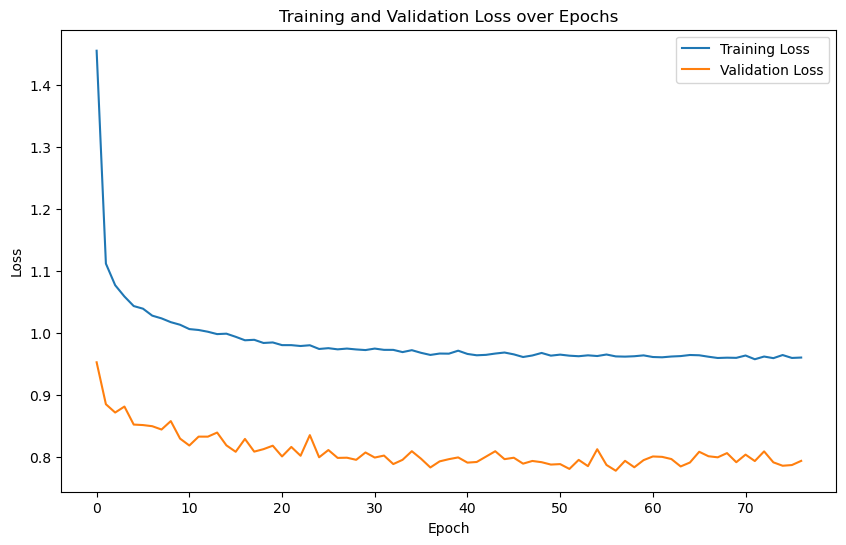

In [18]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/merfish_human_neocortex_gp_mask_finetune_full_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/merfish_human_neocortex_gp_mask_finetune_full_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [19]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [20]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.7379196446368063
Weighted F1 Score: 0.7363660641824137
Macro F1 Score: 0.7149078990291986
Random Guess Accuracy: 0.05408382924188506
                          precision    recall  f1-score   support

       Astrocyte-Fibrous       0.72      0.82      0.76      2056
  Astrocyte-Protoplasmic       0.66      0.70      0.68      1958
          EN-IT-Immature       0.71      0.76      0.73      3827
              EN-L2_3-IT       0.71      0.76      0.73      2843
                EN-L4-IT       0.72      0.72      0.72      2585
                EN-L5-ET       0.61      0.52      0.56        98
                EN-L5-IT       0.76      0.80      0.78      1670
              EN-L5_6-NP       0.81      0.75      0.78       344
                EN-L6-CT       0.73      0.73      0.73       778
                EN-L6-IT       0.83      0.82      0.82      1914
                  EN-L6b       0.84      0.73      0.78      1218
              EN-Newborn       0.74      0.62

In [21]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.encoder(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'SSL_GP_FT_{random_seed}'] = SSL_embeddings
new_adata.uns[f'GP_FT_y_test_{random_seed}'] = y_test
new_adata.uns[f'GP_FT_predictions_{random_seed}'] = predictions
new_adata.uns[f'GP_FT_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'GP_FT_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'GP_FT_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

In [22]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "MERSCOPE_human_neocortex_GP_mask_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicor_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['MERSCOPE_human_neocortex'],
    'method': [re.search(r'neocortex_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micor_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micor_f1
1.455	0.953	57	0.778	0.715	0.736	0.738
